MODELO REDES NEURONALES PREDECIR SERIES TEMPORALES LA INTENSIDAD DE LA CARRETERA EN UNA CALLE EN CONCRETO

Realizamos los import necesarios para el desarrollo del modelo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=8,6
from keras.layers import Dense
from keras.layers import LSTM
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


Cargamos el dataset desde local para no hacer la llamada a GCP puesto que sobrepasa la memoria permitida

In [4]:
import pandas as pd
df = pd.read_csv('D:/TFG/VISUALIZACION todo/FicheroDiario_TrafficTotal.csv')
df.head()

D:\Open Data\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5,6,7,8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,idelem,descripcion,accesoAsociado,intensidad,ocupacion,carga,nivelServicio,intensidadSat,error,subarea,st_x,st_y,velocidad,Fecha_hora,Urbano
0,0,0,3409,SEPULVEDA Ø118 N-S (CEBREROS-CJAL. FCO. J. JIM...,240102.0,0,0,0,0,3000.0,N,1718.0,"436004,103195086","4472588,47356732",0,2022-05-02 00:00:10,Y
1,1,1,4739,CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPUL...,240101.0,0,0,0,0,3000.0,N,1718.0,"436039,395885266","4472397,54735486",0,2022-05-02 00:00:10,Y
2,2,2,4740,CJAL. FCO. J. JIMENEZ Ø86 O-E (F. CALVO-ALHAMBRA),240604.0,0,0,0,0,3000.0,N,1712.0,"436728,94576426","4472480,67512345",0,2022-05-02 00:00:10,Y
3,3,3,4741,CJAL. FCO. J. JIMENEZ Ø76 E-O (HURTUMPASCUAL-A...,240602.0,0,0,0,0,3000.0,N,1712.0,"436894,776506751","4472514,84449863",0,2022-05-02 00:00:10,Y
4,4,4,4742,ALHAMBRA Ø23 N-S (CJAL. FCO. J. JIMENEZ -CUART...,241101.0,48,0,2,0,3000.0,N,1712.0,"436809,990969673","4472410,09421372",0,2022-05-02 00:00:10,Y


Filtramos por una calle ejemplo. Como añadido, esto se podría hacer mediante un formulario al usuario

In [5]:
dffilter = df[(df.descripcion == "CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPULVEDA)")]

In [6]:
len(dffilter)

1990

In [7]:
dffilter.head()

,Unnamed: 0,Unnamed: 0.1,idelem,descripcion,accesoAsociado,intensidad,ocupacion,carga,nivelServicio,intensidadSat,error,subarea,st_x,st_y,velocidad,Fecha_hora,Urbano
1,1,1,4739,CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPUL...,240101.0,0,0,0,0,3000.0,N,1718.0,"436039,395885266","4472397,54735486",0,2022-05-02 00:00:10,Y
4472,4472,4472,4739,CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPUL...,240101.0,0,0,0,0,3000.0,N,1718.0,"436039,395885266","4472397,54735486",0,2022-05-02 00:10:12,Y
8943,8943,8943,4739,CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPUL...,240101.0,0,0,0,0,3000.0,N,1718.0,"436039,395885266","4472397,54735486",0,2022-05-02 00:20:11,Y
13414,13414,13414,4739,CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPUL...,240101.0,0,0,0,0,3000.0,N,1718.0,"436039,395885266","4472397,54735486",0,2022-05-02 00:30:10,Y
17885,17885,17885,4739,CJAL. FCO. J. JIMENEZ Ø126 E-O (BERLANAS-SEPUL...,240101.0,7,0,0,0,3000.0,N,1718.0,"436039,395885266","4472397,54735486",0,2022-05-02 00:40:12,Y


Nos quedamos solo con la variable fecha e intensidad de todo el conjunto de datos

In [8]:
dffilter1 = dffilter[['Fecha_hora','intensidad']]

In [9]:
dffilter1.head()

,Fecha_hora,intensidad
1,2022-05-02 00:00:10,0
4472,2022-05-02 00:10:12,0
8943,2022-05-02 00:20:11,0
13414,2022-05-02 00:30:10,0
17885,2022-05-02 00:40:12,7


Convertimos la variable intensidad en numérico

In [10]:
dffilter1 = dffilter1.astype({'intensidad':'int'})

Filtramos por aquellos valores de intensidad positivos

In [11]:
dffilter1 =  dffilter1[(dffilter1.intensidad > 0)]

Ponemos la fecha como índice para poder representarlo luego en una gráfica de líneas

In [12]:
dffilter1 = dffilter1.set_index('Fecha_hora')

In [13]:
dffilter1.shape

(1696, 1)

Representamos la evolución de la intensidad durante el tiempo de la calle seleccionada anteriormente

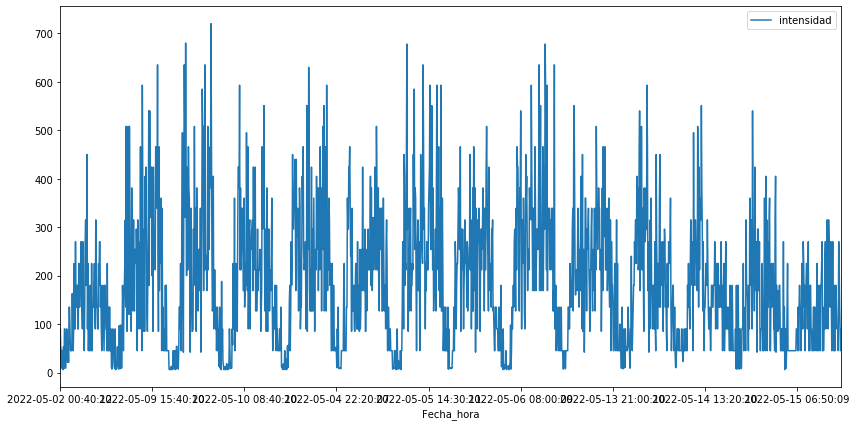

In [14]:
ax = dffilter1.plot(figsize=(14, 7))

Escalamos los datos

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
dffilter1 = scaler.fit_transform(dffilter1)

Dividimos el conjunto de datos en train y test

In [16]:
train_size = int(len(dffilter1) * 0.8)
test_size = len(dffilter1) - train_size
train = dffilter1[0:train_size,:]
test = dffilter1[train_size:len(dffilter1),:]

Hacemos que cada entrenamiento tenga 30 datos de la historia y una etiqueta para el valor real que debe predecir el modelo

In [17]:
def create_dataset(dffilter1, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dffilter1)-look_back-1):
        a = dffilter1[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dffilter1[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
  
  # reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)

(1325, 30)


Se reformulan los datos

In [18]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

Se construye el modelo

In [19]:
from keras.layers import Dropout
from keras.layers import Bidirectional
model=Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(look_back,1)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='sigmoid', return_sequences=False))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

Se entrena el modelo

In [20]:
Xdata_train=[]
Ydata_train=[]

Xdata_train, Ydata_train = create_dataset(train, look_back)
Xdata_train = np.reshape(Xdata_train, (Xdata_train.shape[0], Xdata_train.shape[1], 1))

#training for all data
history = model.fit(Xdata_train,Ydata_train,batch_size=1,epochs=1,shuffle=False)

Epoch 1/1
1325/1325 [==============================] - 104s 79ms/step - loss: 0.0409


Se hacen las predicciones y se calcula el RMSE

In [21]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 219.50 RMSE
Test Score: 144.98 RMSE


Se representa visualmente el resultado obtenido

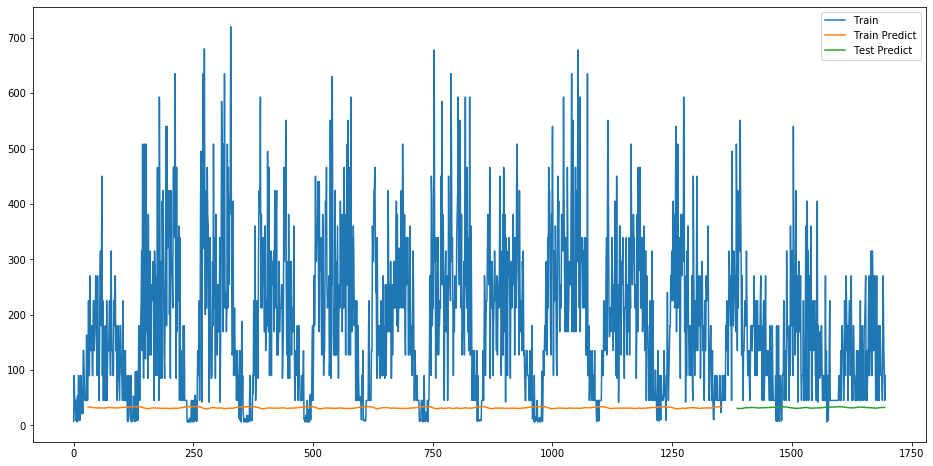

In [22]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dffilter1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dffilter1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dffilter1)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(dffilter1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Train','Train Predict','Test Predict'],loc='best')
plt.show()